## 1. Introduction ##
This is a Keras based implementation of the algorithm detailed in the paper [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Gatys et al.

Inspiration came from an exercise in the [Convolutional Neural Networks](https://www.coursera.org/learn/convolutional-neural-networks/home/welcome) course from Coursera.

The idea behind the algorithm is to take the essence of a Style image (**S**), apply it on the Content image (**C**) and create the Generated image (**G**).

**G** is basically **C** recreated in the style of **S**.

The paper describes how a pretrained VGG19 model can be used for the purpose:
1. Get the activations of a particular layer (*content features*) of VGG19 for **C**.
2. Get the activations of a particular set of layers (*style features list*) of VGG19 for **S**.
3. Start with a randomly generated initial image **G** that is of the same dimensions as **C** & **S**.
4. For the same layer of VGG19 as **C**, get the activations for **G** (*generated features*).
5. For the same set of layers of VGG19 as **S**, get the activations for **G** (*generated features list*).
6. Calculate the ***content cost*** (how different is **G** from **C**?) as a function of *content features* & *generated features*.
7. Calculate the ***style cost*** (how different in style is **G** from **S**?) as a function of *style features list* & *generated features list*.
8. Calculate the *total variation loss* for **G**, which is a measure of randomness of its pixels.
9. ***Total cost*** is the weighted sum of ***content cost***, ***style cost*** & ***total variation loss***.
10. Use an optimization engine to tweak **G** with an object to bring down the ***total cost***.
11. Repeat steps 4 through 10 for a preset number of iterations.

In [1]:
import numpy as np

from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications import vgg19
from keras.applications.vgg19 import preprocess_input

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline

Using TensorFlow backend.


### 2. Constants declaration ###
All the constants used in the program are declared here
1. Input image (content & style) and output image (generated) dimensions
2. URL reference to the content & style images
3. Name of VGG19 layer whose activations for content image will be used for computing cost - this is from the paper.
4. Names of VGG19 layers whose activations for style image will be used for computing cost - this list is from the paper.
5. Weights for content cost, style cost & total variation loss while calculating total cost
6. Number of iterations the generated image needs to be tweaked while minimizing the total cost.
7. For each of the R, G & B channels, the mean color numbers as learnt from the ImageNet training set.

In [2]:
image_height = 600
image_width = 800

content_image_url = 'images/mountain-village-winter.jpg'
content_layer = 'block4_conv2'
content_weight = 0.00025

style_image_url = 'images/styles/vangogh.jpg'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
style_layer_weights = {'block1_conv1': 1.,
                       'block2_conv1': 1.,
                       'block3_conv1': 1.,
                       'block4_conv1': 1.,
                       'block5_conv1': 1.}
style_weight = 100.

total_variation_weight = 100.

num_iterations = 200
rgb_means = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

### 3. Loading C & S images ###

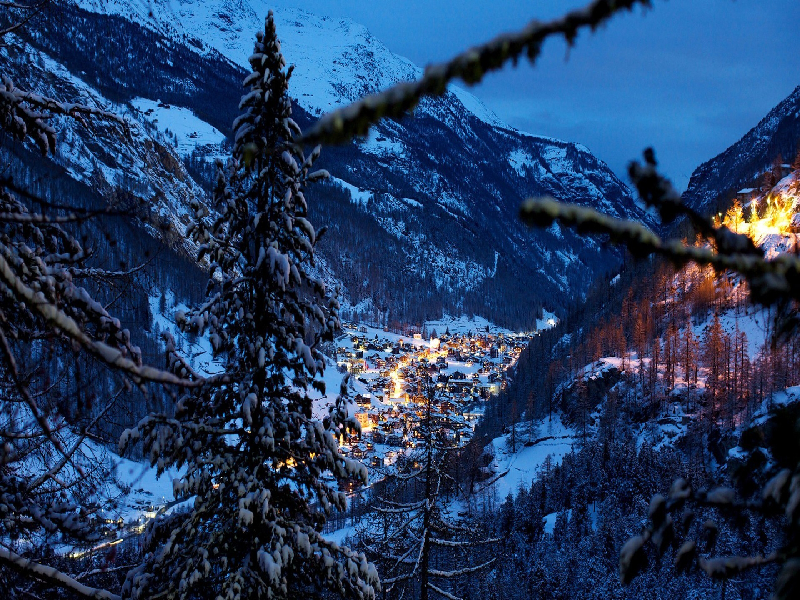

In [3]:
content_image = Image.open(content_image_url)
content_image = content_image.resize((image_width, image_height))
content_image

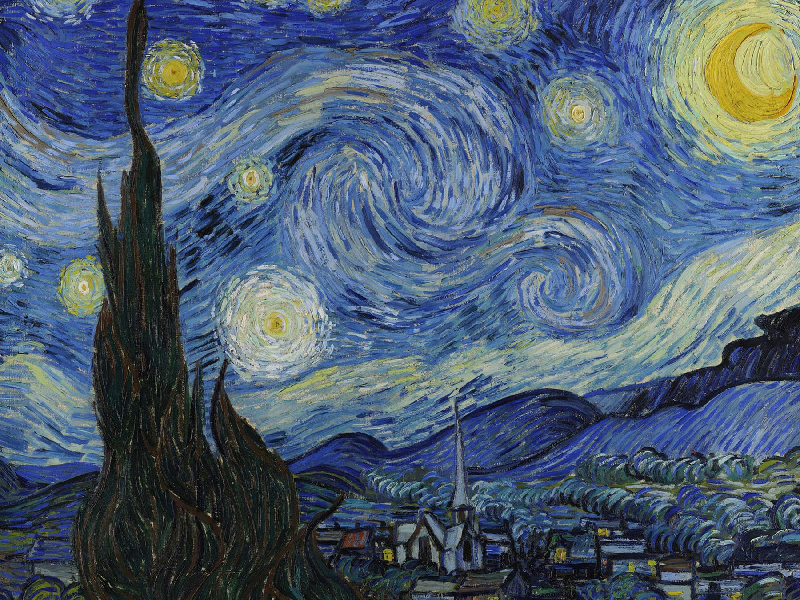

In [4]:
style_image = Image.open(style_image_url)
style_image = style_image.resize((image_width, image_height))
style_image

### 4. Preparing C & S images
Transform the content & style images to the input format expected by the pre-trained VGG19 model:
1. Convert the images into multidimensional numeric arrays (image data).
2. Reshape the image data from the shape `(height, width, channels)` to `(1, height, width, channels)`.
3. Normalize the image data: for each channel, substract from pixel values, the corresponding means computed by ImageNet training set for that channel.
4. Finally, reverse the channel order from RGB to BGR (fourth dimension).

In [5]:
content = np.asarray(content_image, dtype='float32')
content = np.reshape(content, ((1,) + content.shape))
content -= rgb_means
content = content[:, :, :, ::-1]

style = np.asarray(style_image, dtype='float32')
style = np.reshape(style, ((1,) + style.shape))
style -= rgb_means
style = style[:, :, :, ::-1]

### 5. Loading VGG19 ###
Load the pretrained VGG19 model. Define a wrapper Keras model that
- Takes in **C**, **S** or **G** as input.
- Produces as an output list, the activations of the particular VGG19 layers defined in the paper.

The first element of the output list is the activation tensor corresponding to `content_layer`. The remaining elements in the list are the activation tensors for `style_layers`.

In [6]:
vgg19_model = vgg19.VGG19(include_top=False, weights='imagenet')

outputs = [vgg19_model.get_layer(style_layer).output for style_layer in style_layers]
outputs = [vgg19_model.get_layer(content_layer).output] + outputs

model = Model(inputs=vgg19_model.input, outputs=outputs)

### 6. Cost Calculations
#### 6.1 Content cost
##### How different is **G** from **C**?
Formula to calculate the content cost: $\frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $, where $n_H$ is the `image_height`, $n_W$ is the `image_width` and $n_C$ is the number of channels in the image, which is 3 (Red, Green & Blue). $a^{(C)}$ and $a^{(G)}$ are *content features* and *generated features* respectively.

Since the divisor is pretty much a constant, instead of implementing that in code, it is incorporated into the `content_weight` constant. So formula implemented in code is $\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $

In [7]:
def content_cost(content, generated):
    return K.sum(K.square(content - generated))

#### 6.2 Style cost
##### How different in style is **G** from **S**?
Formula to calculate the style cost: $\frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2 $, where $G^{(S)}$ and $G^{(G)}$ are the ***Gram Matrices*** for activations of a particular VGG19 layer for **S** and **G** respectively.

Elements of the ***Gram Matrix*** give a measure of how frequently the corresponding features in the layer activate together. It is this characteristic of ***Gram Matrix*** that we leverage to determine how much **S** and **G** differ in style.

In [8]:
def style_costs(style_features_list, generated_features_list):
    def style_layer_cost(style, generated):
        def gram_matrix(activation, c):
            A = K.reshape(K.transpose(activation), [c, -1])
            return K.dot(A, K.transpose(A))
        
        m, h, w, c = style.shape
        style_gram = gram_matrix(style, c)
        generated_gram = gram_matrix(generated, c)
        
        return K.sum(K.square(style_gram - generated_gram)) / ((c ** 2) * ((h * w) ** 2))
    
    costs = []
    for index in range(5):
        style_features = style_features_list[index]
        generated_features = generated_features_list[index]
        layer_weight = style_layer_weights[style_layers[index]]
        
        costs.append(layer_weight * style_layer_cost(style_features, generated_features))
        
    return costs 

#### 6.3 Total Variation Loss
##### How noisy is **G** ?
This gives a measure of noisiness for the generated image **G**.

In [9]:
def total_variation_loss(x):
    a = K.square(x[:, :image_height-1, :image_width-1, :] - x[:, 1:, :image_width-1, :])
    b = K.square(x[:, :image_height-1, :image_width-1, :] - x[:, :image_height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

### 7. Activations for C & S
Make predictions on **C** and **S** using the wrapper Keras model around VGG19.

For *content features*, pick only activations corresponding to layer referred to by `content_layer`.

For *style features list*, pick all activations for all layers listed in `style_layers`.

In [10]:
content_features = model.predict(content)[0]
style_features_list = model.predict(style)[1:]

### 8. Activations for randomly initiated G

Since **G** is essentially recreated **C**, random initial value for **G** is seeded off of **C**.

Then using the wrapper Keras model, *generated features* and *generted features list* are computed.

In [11]:
random_image_data = np.random.uniform(-20, 20, content.shape).astype('float32')
random_image_data = (random_image_data + content) / 2
generated_v = K.variable(random_image_data)

features = model(generated_v)
generated_features = features[0]
generated_features_list = features[1:]

### 9. Total Cost calculation
***Total cost*** is the weighted sum of ***content cost***, ***style cost*** & ***total variation loss***.

In [12]:
content_cost_v = content_cost(content_features, generated_features)
style_costs_v = style_costs(style_features_list, generated_features_list)
total_variation_loss_v = total_variation_loss(generated_v)

cost = content_weight * content_cost_v

for index in range(5):
    cost += style_weight * style_costs_v[index]
        
cost += total_variation_weight * total_variation_loss_v

### 10. Optimization of G
Using an optimizer, iteratively tweak the value of **G** so the ***total cost*** comes down. The value of **G** corresponding to the lowest ***total cost*** is the generated image of interest.

In [13]:
#https://github.com/fchollet/keras/issues/4843
optimizer = Adam(lr=5.0)
updates = optimizer.get_updates([generated_v], [], [cost])

dummy_ph = K.placeholder((1,), dtype=np.float32)
train_step = K.function([dummy_ph], [cost, content_cost_v, generated_v], updates=updates)

minimum_cost = float('inf')
minimum_cost_image = None
for i in range(num_iterations):
    cost_value, content_cost_value, generated_image = train_step([[1.]])

    if(cost_value < minimum_cost):
        minimum_cost = cost_value
        minimum_cost_image = generated_image

    if i%20 == 0:
        print("Iteration " + str(i) + ". Cost: " + str(cost_value))
        
img = minimum_cost_image.squeeze()
print("Minimum cost: " + str(minimum_cost))

Iteration 0. Cost: 8.15412e+12
Iteration 20. Cost: 6.37498e+11
Iteration 40. Cost: 2.98945e+11
Iteration 60. Cost: 2.20641e+11
Iteration 80. Cost: 1.77336e+11
Iteration 100. Cost: 1.69762e+11
Iteration 120. Cost: 1.47029e+11
Iteration 140. Cost: 1.53298e+11
Iteration 160. Cost: 1.70582e+11
Iteration 180. Cost: 1.34922e+11
Minimum cost: 1.34368e+11


### 11. Render & Conclude
Transform the generated image into a standard format
1. Reshape the image data to `(1, height, width, channels)`.
2. Restore the channel order from BGR to RGB (fourth dimension).
3. De-normalize the image data: for each channel, add to pixel values, the corresponding means computed by ImageNet training set for that channel.
4. Clip to acceptable pixel value ranges, convert data types & display.

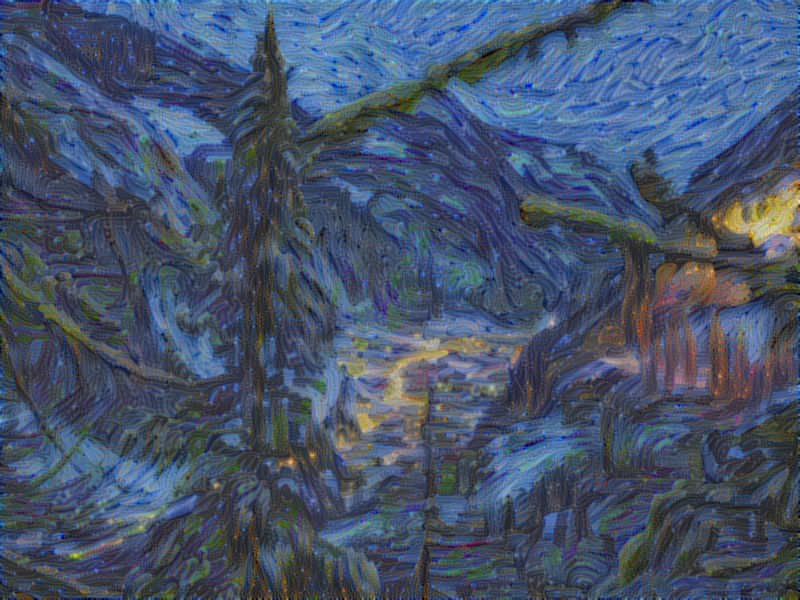

In [14]:
img = img.reshape((1, image_height, image_width, 3))
img = img[:, :, :, ::-1]

img += rgb_means

img = img.reshape((image_height, image_width, 3))
img = np.clip(img, 0, 255).astype('uint8')

Image.fromarray(img)